<a href="https://colab.research.google.com/github/rahvlrawat/Spoiler-Alert/blob/main/Spoiler_Alert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports/Installations 

In [1]:
import os

In [2]:
os.system('pip install -q kaggle')
os.system('mkdir ~/.kaggle')
os.system('cp /content/drive/MyDrive/kaggle.json   ~/.kaggle/')
os.system('chmod 600 ~/.kaggle/kaggle.json')
os.system('kaggle datasets download -d  rmisra/imdb-spoiler-dataset')
os.system('kaggle datasets download -d   rtatman/glove-global-vectors-for-word-representation')
os.system('unzip  /content/imdb-spoiler-dataset.zip')
os.system('unzip /content/glove-global-vectors-for-word-representation.zip')



0

In [3]:
pip install --user -U nltk

     |████████████████████████████████| 1.4MB 4.3MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434677 sha256=41616f1e098d7370c4d6b2abe59bbf1171c942bece1a985365e9efbc2d6733fe
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import norm

from datetime import datetime
import re
from wordcloud import WordCloud, STOPWORDS

from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

import re
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Data Preprocessing

In [5]:
df_reviews = pd.read_json('/content/IMDB_reviews.json', lines=True)
df_details = pd.read_json('/content/IMDB_movie_details.json', lines=True)


In [6]:
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [7]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [8]:
df_reviews.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'rating', 'review_summary'],
      dtype='object')

In [9]:
df_details.columns

Index(['movie_id', 'plot_summary', 'duration', 'genre', 'rating',
       'release_date', 'plot_synopsis'],
      dtype='object')

In [10]:
df=pd.merge(df_reviews,df_details,on='movie_id')

In [11]:
df.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'rating_x', 'review_summary', 'plot_summary', 'duration', 'genre',
       'rating_y', 'release_date', 'plot_synopsis'],
      dtype='object')

In [12]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."


In [13]:
df.rename(columns = {'rating_x':'userrating','rating_y':'actualrating'}, inplace = True)

In [14]:
df.drop(['review_date','duration','release_date'],axis=1,inplace=True)

In [15]:
df.head()

,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,genre,actualrating,plot_synopsis
0,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,"[Crime, Drama]",9.3,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,"[Crime, Drama]",9.3,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,"[Crime, Drama]",9.3,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
3,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,"[Crime, Drama]",9.3,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
4,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,"[Crime, Drama]",9.3,"In 1947, Andy Dufresne (Tim Robbins), a banker..."


In [18]:
df.dtypes

movie_id           object
user_id            object
is_spoiler           bool
review_text        object
userrating          int64
review_summary     object
plot_summary       object
genre              object
actualrating      float64
plot_synopsis      object
dtype: object

In [19]:
df['is_spoiler']=df['is_spoiler']+0

In [23]:
spoilers = df[df.is_spoiler == 1].sample(frac=1).reset_index(drop=True)
notspoilers = df[df.is_spoiler == 0].sample(frac=1).reset_index(drop=True)


In [25]:
len(spoilers),len(notspoilers)

(150924, 422982)

In [26]:
# train set
df = pd.concat([spoilers.head(100000), others.head(100000)]).sample(frac=1).reset_index(drop=True)

# test set
test = pd.concat([spoilers.tail(50000), others.tail(100000)]).sample(frac=1).reset_index(drop=True)

# Movie spoiler ratio

In [28]:
total_spoilers= df.groupby(by='movie_id').is_spoiler.agg(['sum']).reset_index().rename(columns={'sum':'total_spoilers'})

In [29]:
total_movies = df.groupby(by='movie_id').movie_id.agg(['count']).reset_index().rename(columns={'count':'total_movies'})

In [30]:
msr = pd.merge(total_spoilers,total_movies, on='movie_id')

In [31]:
msr['msr']=msr.total_spoilers/msr.total_movies

In [32]:
msr.head()

,movie_id,total_spoilers,total_movies,msr
0,tt0012349,18,73,0.246575
1,tt0015864,25,88,0.284091
2,tt0017136,49,237,0.206751
3,tt0017925,35,136,0.257353
4,tt0018455,41,121,0.338843


In [33]:
msr.drop(['total_spoilers','total_movies'], axis=1, inplace=True)

In [34]:
df=pd.merge(df,msr,on='movie_id')

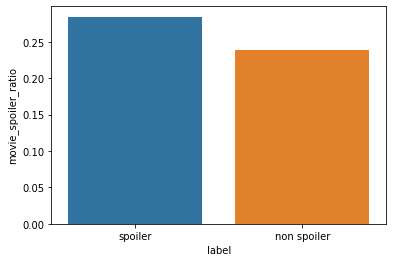

In [35]:
df_temp = pd.DataFrame({"label":["spoiler", "non spoiler"],
                        "movie_spoiler_ratio":[df[df.is_spoiler==1].msr.mean(), 
                                            df[df.is_spoiler==0].msr.mean()]})
sns.barplot(x = "label", y = "movie_spoiler_ratio", data = df_temp);

#User Spoiler Ratio 

In [37]:
total_user_spoilers = df.groupby(by='user_id').is_spoiler.agg(['sum']).reset_index().rename(columns={'sum':'total_user_spoilers'})


In [38]:
total_users = df.groupby(by='user_id').user_id.agg(['count']).reset_index().rename(columns={'count':'total_users'})


In [39]:
usr = pd.merge(total_user_spoilers,total_users, on='user_id')

In [40]:
usr['usr']=usr.total_user_spoilers / usr.total_users

In [41]:
usr.drop(['total_user_spoilers','total_users'], axis=1,inplace=True)

In [42]:
df= pd.merge(df, usr, on='user_id')

In [43]:
df_temp = pd.DataFrame({"label":["spoiler", "non spoiler"],
                      "users_spoiler_ratio":[df[df.is_spoiler==1].usr.mean(), 
                                            df[df.is_spoiler==0].usr.mean()]})


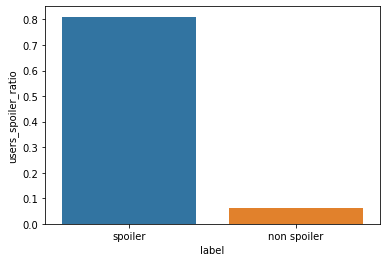

In [44]:
sns.barplot(x = "label", y = "users_spoiler_ratio", data = df_temp)

In [45]:
# Todo : 
Try to show graph distribution for user /movie spoilers  


SyntaxError: ignored

# Some Genres tend to have more spoilers

<h2>Some genre categories combined together will produce more spoilers so our goal is to segregate those particular genre category combos and use them to predict if movie can have spoiler review or not</h2>

In [50]:
genres= np.unique(np.array(' '.join(df.genre.str.join(' ')).split()))

In [51]:
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western'], dtype='<U9')

In [52]:
genre_df=pd.DataFrame()

In [53]:
for i in genres:
    genre_df[i.lower()]=0

In [54]:
c=0

In [55]:
df.isnull()

,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,genre,actualrating,plot_synopsis,msr,usr
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
399995,False,False,False,False,False,False,False,False,False,False,False,False
399996,False,False,False,False,False,False,False,False,False,False,False,False
399997,False,False,False,False,False,False,False,False,False,False,False,False
399998,False,False,False,False,False,False,False,False,False,False,False,False


In [56]:
for i,data in df_details.iterrows():
    #Assigns details pertaining to a movie to a variable
    details=df_details[df_details.movie_id==data['movie_id']]
    genre_df.at[i,'movie_id']=data['movie_id']
    for genre in genres:
        #Checks if movie belongs to the genre or not 
        genre_df.at[i,genre.lower()]=int(genre in details['genre'].tolist()[0])

In [57]:
genre_df.head()

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,film-noir,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western,movie_id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,tt0105112
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tt1204975
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,tt0243655
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,tt0040897
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,tt0126886


In [58]:
df_temp= pd.merge(df, genre_df, on="movie_id")

In [59]:
df_temp.head()

,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,genre,actualrating,plot_synopsis,msr,usr,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,film-noir,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western
0,tt0926084,ur22236153,0,Whenever a Harry Potter book is converted into...,6,Delusions of Grandeur,Voldemort's power is growing stronger. He now ...,"[Adventure, Family, Fantasy]",7.7,The film begins with Harry Potter (Daniel Radc...,0.36983,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0926084,ur8760936,0,"Harry Potter and The Deathly Hallows, Part 1 i...",10,The Highest Praise,Voldemort's power is growing stronger. He now ...,"[Adventure, Family, Fantasy]",7.7,The film begins with Harry Potter (Daniel Radc...,0.36983,0.428571,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0926084,ur6289903,1,"First of all, I must warn young kids who are h...",10,Get Ready for the final showdown!,Voldemort's power is growing stronger. He now ...,"[Adventure, Family, Fantasy]",7.7,The film begins with Harry Potter (Daniel Radc...,0.36983,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0926084,ur22102833,0,"The acting has come a LONG way and so far, thi...",9,Brilliant,Voldemort's power is growing stronger. He now ...,"[Adventure, Family, Fantasy]",7.7,The film begins with Harry Potter (Daniel Radc...,0.36983,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0926084,ur46804064,0,The ending is closer and the movies are worse....,3,These are getting worse,Voldemort's power is growing stronger. He now ...,"[Adventure, Family, Fantasy]",7.7,The film begins with Harry Potter (Daniel Radc...,0.36983,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
df_temp.shape

(400000, 33)

In [61]:
e = 0.001
gsr = np.zeros(len(genres))
for i,g in enumerate(genres):
    # i.e. total no. of reviews with spoiler belonging to a genre /total no. of reviews of movie genre
    gsr[i] = df_temp[(df_temp.is_spoiler==1) &
                                     (df_temp[g.lower()]==1)].shape[0] / (df_temp[df_temp[g.lower()]==1].shape[0]
                                                                          +e)

In [62]:
gsr

array([0.26935532, 0.27290849, 0.24566051, 0.22858502, 0.20354187,
       0.23355822, 0.24329733, 0.25652094, 0.26711026, 0.26779914,
       0.22204921, 0.28231313, 0.20532378, 0.18709838, 0.27588223,
       0.22307143, 0.29841888, 0.23230765, 0.26972779, 0.23140147,
       0.24680844])

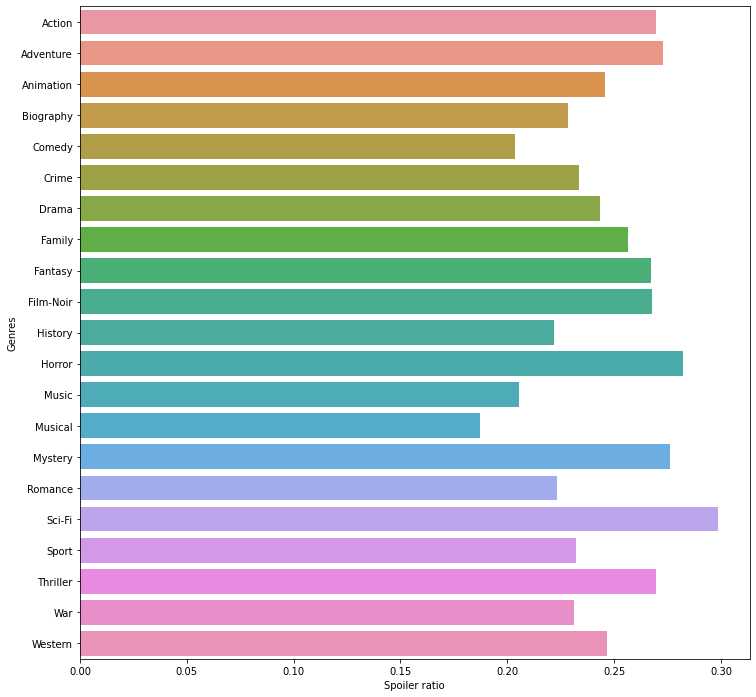

In [63]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x=gsr,y=genres)
ax.set(xlabel="Spoiler ratio",ylabel="Genres");
plt.show();

# Calculating spoiler ratio for combination of genres 

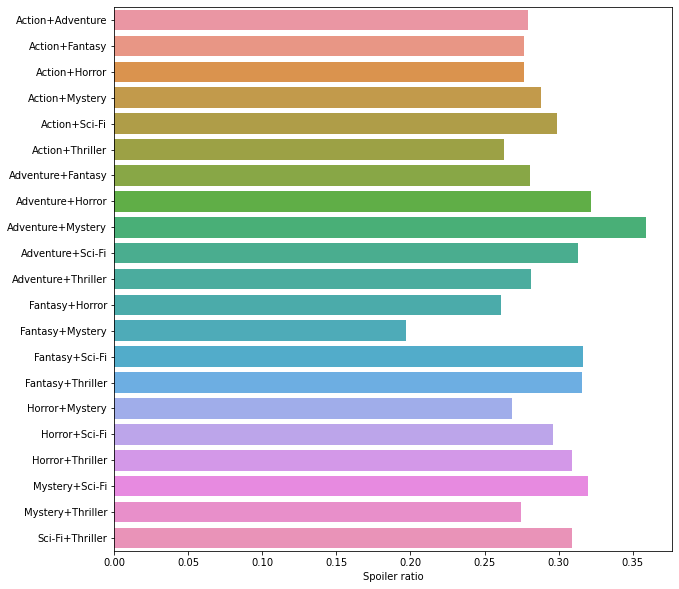

In [64]:
e = 0.001
selected = ["Action","Adventure","Fantasy","Horror","Mystery","Sci-Fi","Thriller"]

genre_2_labels = []
genre_2_ratios = []

i=0
while i < len(selected):
    j = i+1
    while j < len(selected):
        # i.e. ratio of total movies reviews having spoilers belonging to selected genres / total reviews of the movies of selected genres
        genre_2_labels.append(selected[i]+"+"+selected[j])
        spoilers = df_temp[(df_temp[selected[i].lower()]==1) & (df_temp[selected[j].lower()]==1) & df_temp.is_spoiler].shape[0]
        total = df_temp[(df_temp[selected[i].lower()]==1) & (df_temp[selected[j].lower()]==1)].shape[0]
        genre_2_ratios.append(spoilers / (total+e))
        j+=1
    i+=1
plt.figure(figsize=(10,10))    
ax = sns.barplot(x=genre_2_ratios,y=genre_2_labels)
ax.set(xlabel="Spoiler ratio");
plt.show();

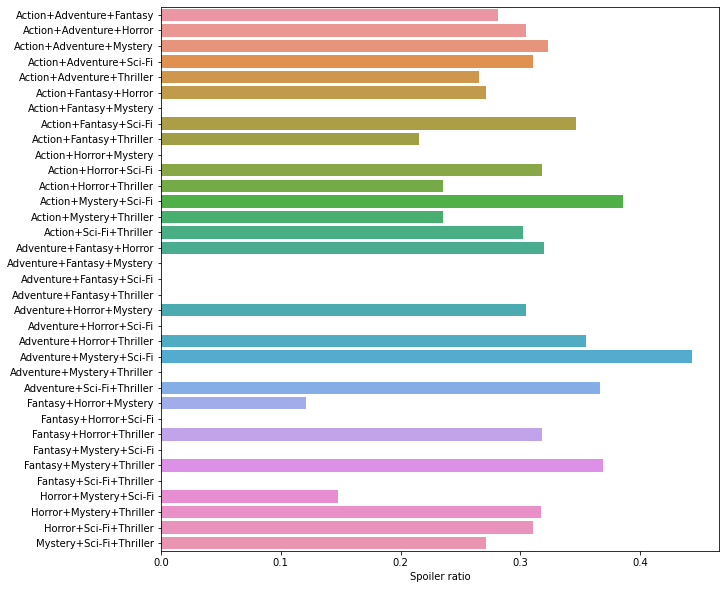

In [65]:
genre_3_labels = []
genre_3_ratios = []

i=0
while i < len(selected):
    j = i+1
    while j < len(selected):
        k = j+1
        while k < len(selected):
            genre_3_labels.append(selected[i]+"+"+selected[j]+"+"+selected[k])
            spoilers = df_temp[(df_temp[selected[k].lower()]==1) & (df_temp[selected[i].lower()]==1) & (df_temp[selected[j].lower()]==1) & df_temp.is_spoiler].shape[0]
            total = df_temp[(df_temp[selected[k].lower()]==1) & (df_temp[selected[i].lower()]==1) & (df_temp[selected[j].lower()]==1)].shape[0]
            genre_3_ratios.append(spoilers / (total+e))
            k+=1
        j+=1
    i+=1
    
plt.figure(figsize=(10,10))
ax = sns.barplot(x=genre_3_ratios,y=genre_3_labels)
ax.set(xlabel="Spoiler ratio");
plt.show();

In [66]:
def isListSubset(a,b):
    count = 0
    for i,v in enumerate(a):
        if v in b:
            count += 1
    return count == len(a)

def getGenreRatio(genres):
    return isListSubset(["Fantasy","Sci-Fi"], genres) or isListSubset(["Adventure","Mystery"], genres) or isListSubset(["Action","Mystery","Sci-Fi"], genres) or isListSubset(["Adventure","Horror","Thriller"], genres) or isListSubset(["Adventure","Thriller"], genres) or isListSubset(["Fantasy","Mystery"], genres)

In [67]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [68]:
df['gsr'] = pd.merge(df,df_details.drop(['genre'],axis=1),on="movie_id").genre.apply(getGenreRatio)+0

In [69]:
df.head()

,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,genre,actualrating,plot_synopsis,msr,usr,gsr
0,tt0926084,ur22236153,0,Whenever a Harry Potter book is converted into...,6,Delusions of Grandeur,Voldemort's power is growing stronger. He now ...,"[Adventure, Family, Fantasy]",7.7,The film begins with Harry Potter (Daniel Radc...,0.369830,0.0,0
1,tt0499549,ur22236153,0,First of all I would like to place upon my sin...,10,The Greatest Movie Ever Made....,"When his brother is killed in a robbery, parap...","[Action, Adventure, Fantasy]",7.8,Opening scene: a camera sweeps high across the...,0.235632,0.0,0
2,tt1228705,ur22236153,0,Before Iron Man was made John Favreau said he ...,10,Iron Man 2 = Double Awesomeness!!,With the world now aware of his dual life as t...,"[Action, Adventure, Sci-Fi]",7.0,The movie opens several months after the event...,0.320513,0.0,0
3,tt1375666,ur22236153,0,What is the most resilient parasite? An Idea! ...,10,Insanely Brilliant ! Nolan has outdone himself !!,"Dom Cobb is a skilled thief, the absolute best...","[Action, Adventure, Sci-Fi]",8.8,"A young man, exhausted and delirious, washes u...",0.318548,0.0,0
4,tt1345836,ur22236153,0,You just don't watch a Nolan movie. You experi...,8,The surprisingly fitting epic finale!,Despite his tarnished reputation after the eve...,"[Action, Thriller]",8.4,Commissioner James Gordon (Gary Oldman) is del...,0.342975,0.0,0


# Spoiler Text in review 

In [70]:
df[df.review_text.str.contains('SPOILERS')]

,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,genre,actualrating,plot_synopsis,msr,usr,gsr
822,tt0120657,ur0002746,1,(SPOILERS???) I really wanted to like this mov...,5,Plot holes & miscasting spoil this great idea.,"In AD 922, Arab Ahmad Ibn Fadlan is sent to th...","[Action, Adventure, History]",6.6,Based on award-winning author Michael Crichton...,0.129032,0.691176,0
829,tt0209163,ur0002746,1,This movie was a slight bit of a let down. Ho...,8,"Fun to watch, but isn't that much original.","Many years ago, in Ancient Egypt, the Scorpion...","[Action, Adventure, Fantasy]",6.3,"In 3067 BC, a warrior known as the Scorpion Ki...",0.109375,0.691176,0
863,tt0253754,ur0002746,1,(SPOILERS!!)Got a chance to see this and it tu...,5,Makes Insurrection look good.,After a joyous wedding between William Riker a...,"[Action, Adventure, Sci-Fi]",6.4,"At the beginning of the movie, we first see a ...",0.316354,0.691176,0
2202,tt0926084,ur22750085,1,WARNING: Typically I keep my reviews spoiler f...,8,"Somewhat Rushed, but Overall Good",Voldemort's power is growing stronger. He now ...,"[Adventure, Family, Fantasy]",7.7,The film begins with Harry Potter (Daniel Radc...,0.369830,0.133333,0
2212,tt0417741,ur22750085,1,Harry Potter and the Half-Blood Prince Rating:...,9,An Imperfect Adaptation but Still a Good Film,In the sixth year at Hogwarts School of Witchc...,"[Adventure, Family, Fantasy]",7.6,Scarred by his experience at the Ministry of M...,0.458848,0.133333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
398855,tt0104797,ur39905647,1,**MAY CONTAIN SPOILERS**Spike Lee has beautifu...,9,The Story that Can't Be Told Enough,"Biograpical epic of Malcolm X, the legendary A...","[Biography, Drama, History]",7.7,"As the opening credits roll, we hear Malcolm X...",0.274725,1.000000,0
399471,tt0120890,ur1233308,1,"This review might contain SPOILERS, read at yo...",5,Overcomplicated storyline makes it less enjoyable,"In south Florida, a high school counselor is a...","[Crime, Drama, Mystery]",6.5,"Two female students -- wealthy, popular Kelly ...",0.140449,1.000000,0
399572,tt0109424,ur23097907,0,WARNING: SMALL SPOILERS MAY BE GIVEN BELOWToda...,10,"A midst pining, sometimes a second chance is r...",Wong Kar-Wai's movie about two love-struck cop...,"[Crime, Drama, Romance]",8.1,"The movie comprises two different stories, tol...",0.263736,0.000000,0
399598,tt0100029,ur3128262,1,This movie is very good. I watched this from a...,9,One of Van Dammes best!,Lyon Gaultier is a deserter in the Foreign Leg...,"[Action, Crime, Drama]",6.2,A man is buying drugs from a dealer until his ...,0.311111,1.000000,0


In [71]:
df['spoiltext'] = df.review_text.str.contains('SPOILERS')+0

In [72]:
df.head()

,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,genre,actualrating,plot_synopsis,msr,usr,gsr,spoiltext
0,tt0926084,ur22236153,0,Whenever a Harry Potter book is converted into...,6,Delusions of Grandeur,Voldemort's power is growing stronger. He now ...,"[Adventure, Family, Fantasy]",7.7,The film begins with Harry Potter (Daniel Radc...,0.369830,0.0,0,0
1,tt0499549,ur22236153,0,First of all I would like to place upon my sin...,10,The Greatest Movie Ever Made....,"When his brother is killed in a robbery, parap...","[Action, Adventure, Fantasy]",7.8,Opening scene: a camera sweeps high across the...,0.235632,0.0,0,0
2,tt1228705,ur22236153,0,Before Iron Man was made John Favreau said he ...,10,Iron Man 2 = Double Awesomeness!!,With the world now aware of his dual life as t...,"[Action, Adventure, Sci-Fi]",7.0,The movie opens several months after the event...,0.320513,0.0,0,0
3,tt1375666,ur22236153,0,What is the most resilient parasite? An Idea! ...,10,Insanely Brilliant ! Nolan has outdone himself !!,"Dom Cobb is a skilled thief, the absolute best...","[Action, Adventure, Sci-Fi]",8.8,"A young man, exhausted and delirious, washes u...",0.318548,0.0,0,0
4,tt1345836,ur22236153,0,You just don't watch a Nolan movie. You experi...,8,The surprisingly fitting epic finale!,Despite his tarnished reputation after the eve...,"[Action, Thriller]",8.4,Commissioner James Gordon (Gary Oldman) is del...,0.342975,0.0,0,0


# For Rating

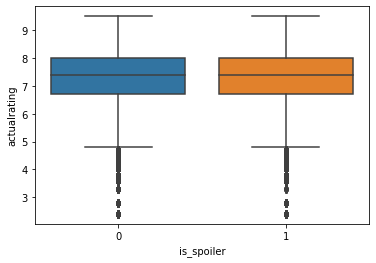

In [73]:
#sns.boxplot(x=df_reviews.is_spoiler,y=df_reviews.rating)
sns.boxplot(x= df.is_spoiler,y=df.actualrating)

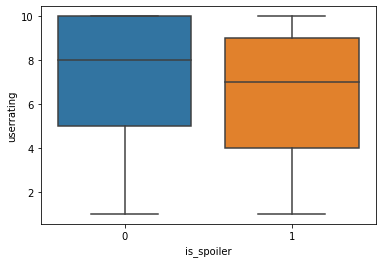

In [74]:
sns.boxplot(x= df.is_spoiler,y=df.userrating)

As can be observed from the boxplots above,the review ratings don't have much to offer regarding the spoilers .

#  Matching Text from reviews with plot summary


Comparing the similarity of spoiler reviews to movie plot summary will be a good indicator as to if a review contains spoiler or not 

In [75]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [76]:
stopwords=set(stopwords.words('english'))

In [77]:
len(stopwords)

179

In [78]:
stopwords_dict=Counter(stopwords)

In [79]:
def preprocesstext(review):
    review=review.lower()
    review=re.sub('[^a-zA-Z]',' ',review)
    words=review.split()
    word=[word for word in words if word not in stopwords_dict]
    review=" ".join(words)
    return review

In [80]:
df.review_text=df.review_text.apply(preprocesstext)

In [81]:
df.review_text

0         whenever a harry potter book is converted into...
1         first of all i would like to place upon my sin...
2         before iron man was made john favreau said he ...
3         what is the most resilient parasite an idea ye...
4         you just don t watch a nolan movie you experie...
                                ...                        
399995    the post is a solid hollywood retelling of the...
399996    this movie is a perfect portrayal of the nutcr...
399997    the nutcracker has always been a somewhat prob...
399998    as far as i can recall balanchine s alteration...
399999    the best thing about this movie was the orches...
Name: review_text, Length: 400000, dtype: object

Using glove-global-vectors for words.These pre-trained embeddings are used  to quantify word co-occurrence (which also captures some aspects of word meaning). This dataset contains 50-dimensional, 100-dimensional and 200-dimensional pre trained word vectors

In [82]:
#Saving the words and their corresponding vectors in  a dictionary
embeddings=dict()
f=open('/content/glove.6B.50d.txt')
for i in f: 
    values=i.split()
    word=values[0]
    cofss = np.asarray(values[1:], dtype='float32')
    embeddings[word]=cofss
f.close()    

In [83]:
def getAvgWordEmbedding(text):
    words = text.split()
    n = 0
    sumEmbed = np.zeros(50)
    # because 50 dim of word vectors
    
    for word in words:
        if word in embeddings:
            sumEmbed += embeddings[word]
            n += 1
    
    avgEmbed = sumEmbed / n
    return avgEmbed
    
def Dist(e1, e2):
    return np.sum(np.square(e1-e2), axis = 1)

In [84]:
df_details.plot_summary

0       Former CIA analyst, Jack Ryan is in England wi...
1       Billy (Michael Douglas), Paddy (Robert De Niro...
2       The setting is Camp Firewood, the year 1981. I...
3       Fred C. Dobbs and Bob Curtin, both down on the...
4       Tracy Flick is running unopposed for this year...
                              ...                        
1567    Evan Treborn grows up in a small town with his...
1568    Brandon is a 30-something man living in New Yo...
1569    Evacuation of Allied soldiers from the British...
1570    For a while now, beautiful 24-year-old Diana B...
1571    The marriage of David Burgess, a senior execut...
Name: plot_summary, Length: 1572, dtype: object

In [85]:
plot_embed = df.plot_summary.apply(getAvgWordEmbedding)
review_embed = df.review_text.apply(getAvgWordEmbedding)

In [86]:
distance=Dist(np.stack(review_embed),np.stack(plot_embed))

In [87]:
df['distance']=distance

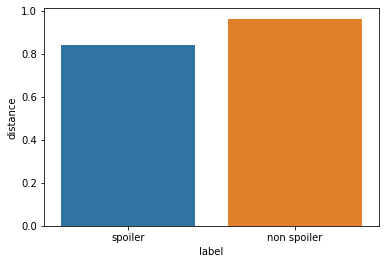

In [88]:
df_temp = pd.DataFrame({"label":["spoiler", "non spoiler"], 
                        "distance":[df[df.is_spoiler==1].distance.mean(), 
                                        df[df.is_spoiler==0].distance.mean()]})
sns.barplot(x = "label", y = "distance", data = df_temp);

As can be seen from all the above new dimensions introduced we don't have a single  criteria to distinguish between spoiler and non spoiler reviews  but its dependent a no. of criterias  so in order to solve this problem we will now look into a way to unify all these criterias using machine learning to help us in separating non spoiler reviews from spoiler reviews.


# Training an SVM model using the newly created dimensions for the reviews

In [89]:
df.columns

Index(['movie_id', 'user_id', 'is_spoiler', 'review_text', 'userrating',
       'review_summary', 'plot_summary', 'genre', 'actualrating',
       'plot_synopsis', 'msr', 'usr', 'gsr', 'spoiltext', 'distance'],
      dtype='object')

In [119]:
x = df[['msr','usr','gsr','distance','spoiltext']]
x = x.fillna(0)

In [120]:
x.shape

(400000, 5)

In [ ]:
model_svm = svm.SVC(gamma='scale',C=10)
model_svm.fit(x, df.is_spoiler)

In [ ]:
preds = model_svm.predict(x)

In [ ]:
print(classification_report(df.is_spoiler, preds))
print(confusion_matrix(df.is_spoiler, preds))

In [ ]:
test1 = pd.merge(test, usr, how = 'left', on = 'user_id')
test1 = pd.merge(test1, msr, how = 'left', on = 'movie_id')
test1['gsr'] = test1.genre.apply(getGenreRatio)+0
test1.review_text = test1.review_text.apply(preprocesstext)
review_embed_test = test1.review_text.apply(getAvgWordEmbedding)
plot_embed_test = test.plot_summary.apply(getAvgWordEmbedding)
test1['distance'] = Dist(np.stack(review_embed_test), np.stack(plot_embed_test))

In [ ]:
test1['spoiltext'] = test1.review_summary.str.contains('SPOILERS')+0

In [ ]:
test1.columns

In [ ]:
x_test = test1[['msr','usr','gsr','distance','spoiltext']]
x_test = x_test.fillna(0)

In [ ]:
predictions_new = model_svm.predict(x_test)

In [ ]:
print(classification_report(test1.is_spoiler, predictions_new))
print(confusion_matrix(test1.is_spoiler, predictions_new))